In [1]:
import pandas
import pathlib
from config import datadir
import numpy
import matplotlib.pyplot as plt
from latex_figure import plotfigure
import scipy.signal as sig
import statsmodels.nonparametric.smoothers_lowess as smoother

import sympy

import pint

In [2]:
excel_directory = pandas.read_excel(datadir/'Data Description.xlsx', parse_dates=True, index_col='Start Date')
excel_directory

,End Date,Equipment,Type,Purpose,Filename,Run,Description
Start Date,,,,,,,
2019-12-06,2019-12-11,pH Probe,Drift,Test Drift on pH probe,20191206 pH Drift 1.txt,1,"long run of pH probe drift, performed inside t..."
2019-12-11,2019-12-17,pH Probe,Drift,Test Drift on pH probe,20191211 pH Drift 2.txt,2,"long run of pH probe drift, performed inside t..."
2019-12-17,2019-12-23,pH Probe,Drift,Test Drift on pH probe,20191217 pH Drift 3.txt,3,"long run of pH probe Drift, circulating ph7 bu..."
2020-01-16,2020-01-16,pH Probe,Step Test,Step Test,20200116 pH Step 3.txt,3,pH stepped outside of rig
2020-01-14,2020-01-14,pH Probe,Step Test,Step Test,20200116 pH Step 1.txt,1,"pH stepped outside of rig. Probe Broke, Dump run"
2020-01-15,2020-01-15,pH Probe,Step Test,Step Test,20200116 pH Step 2.txt,2,pH stepped outside of rig
2020-01-01,2020-01-01,Pumps,Calibration,Calibration,Pump Calibration.xlsx,1,Calibration data for all pumps


In [3]:
glucose_rpm = pandas.read_excel(datadir/"Pump Calibration.xlsx", sheet_name = 2, usecols = ["Rpm", "Volume/Time (ml/s)"], nrows = 13)

In [4]:
glucose_ma = pandas.read_excel(datadir/"Pump Calibration.xlsx", sheet_name = 2, usecols = ["Signal Output (mA)", "200", "100"], nrows = 31)
glucose_ma["Signal Output (mA)"]/=1000

In [5]:
dosing_rpm = pandas.read_excel(datadir/"Pump Calibration.xlsx", sheet_name = 0, usecols = ["Rpm", "Volume/Time (ml/s)"], nrows = 10)

In [6]:
dosing_ma = pandas.read_excel(datadir/"Pump Calibration.xlsx", sheet_name = 0, usecols = ["Signal Output (mA)", "200", "100"], nrows = 31)
dosing_ma["Signal Output (mA)"]/=1000

In [7]:
mineral_rpm = pandas.read_excel(datadir/"Pump Calibration.xlsx", sheet_name = 1, usecols = ["Rpm", "Volume/Time (ml/s)"], nrows = 10)

In [8]:
mineral_ma = pandas.read_excel(datadir/"Pump Calibration.xlsx", sheet_name = 1, usecols = ["Signal Output (mA)", "200", "100"], nrows = 31)
mineral_ma["Signal Output (mA)"]/=1000

In [9]:
rpms = [dosing_rpm['Rpm'], mineral_rpm['Rpm'], glucose_rpm['Rpm']]
vols = [dosing_rpm['Volume/Time (ml/s)'], mineral_rpm['Volume/Time (ml/s)'], glucose_rpm['Volume/Time (ml/s)']]
frac_200 = [dosing_ma['200'], mineral_ma['200'], glucose_ma['200']]
frac_100 = [dosing_ma['100'], mineral_ma['100'], glucose_ma['100']]
frac_avg = [(frac_200[pump] + frac_100[pump])/2 for pump,_ in enumerate(frac_200)]

mas = [dosing_ma['Signal Output (mA)'], mineral_ma['Signal Output (mA)'], glucose_ma['Signal Output (mA)']]

In [10]:
# Names and line types for the different plot series
YNAMES = ["Dosing Pump", "Mineral Pump", "Glucose Pump", "Dosing Pump fit", "Mineral Pump fit", "Glucose Pump fit",]
LINETYPES = ["c:", "b-.", "r--","c.", "bo", "r2"]

aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
HALFSIZE = 3, 3 * aspect_ratio

xlabel = "RPM"
ylabel = "Flowrate (ml/s)"

In [11]:
order = 1

rates_rpm_flow = [(numpy.polyfit(rpms[pump], vols[pump],order)) for pump,_ in enumerate(vols)]

In [12]:
rpm_predictions = numpy.linspace(0,200,10)

In [13]:
rpm_flow_fitlines = [rates_rpm_flow[pump][0]*rpm_predictions + rates_rpm_flow[pump][1] for pump,_ in enumerate(vols)]

for vol_pred in rpm_flow_fitlines:
    rpms.append(rpm_predictions)
    vols.append(vol_pred)

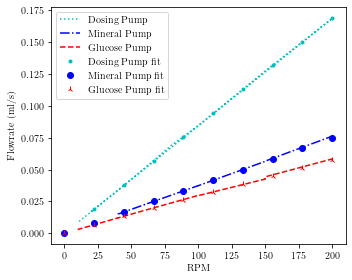

In [14]:
plotfigure(rpms, vols, YNAMES, LINETYPES, xlabel, ylabel, figsize=FULLSIZE, filename=str(datadir)+"/RPM to Flowrate.pdf")

In [15]:
# Names and line types for the different plot series
YNAMES = ["Dosing Pump", "Mineral Pump", "Glucose Pump", "Dosing Pump fit", "Mineral Pump fit", "Glucose Pump fit",]
LINETYPES = ["c-", "b-.", "r--","c.", "bo", "r2"]

aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
HALFSIZE = 3, 3 * aspect_ratio

xlabel = "Control Signal (mA)"
ylabel = "RPM Fraction"

In [16]:
order = 1

rates_mas_rpm = [(numpy.polyfit(mas[pump], frac_avg[pump],order)) for pump,_ in enumerate(mas)]

In [17]:
mas_predictions = numpy.linspace(0,0.02,10)

In [18]:
mas_rpm_fitlines = [rates_mas_rpm[pump][0]*mas_predictions + rates_mas_rpm[pump][1] for pump,_ in enumerate(mas)]

for frac_pred in mas_rpm_fitlines:
    mas.append(mas_predictions)
    frac_avg.append(frac_pred)

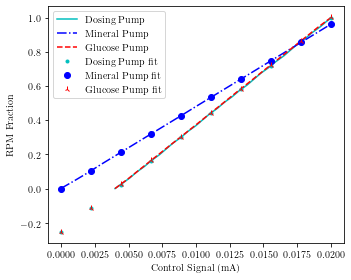

In [19]:
plotfigure(mas, frac_avg, YNAMES, LINETYPES, xlabel, ylabel, figsize=FULLSIZE, filename=str(datadir)+"/CS to RPM.pdf")

In [20]:
for pump,rate_pair in zip(YNAMES, rates_rpm_flow):
    print ("Flowrate Output {} = {} RPM + {}".format( pump, round(rate_pair[0],6), round(rate_pair[1],6)))

Flowrate Output Dosing Pump = 0.000845 RPM + 0.00013
Flowrate Output Mineral Pump = 0.000375 RPM + -1.5e-05
Flowrate Output Glucose Pump = 0.000287 RPM + 0.000435


In [23]:
for pump,rate_pair in zip(YNAMES, rates_mas_rpm):
    print ("RPM Output {} = ( {} mA CS + {} ) x RPM Max {}".format( pump, round(rate_pair[0],6), round(rate_pair[1],6), pump))

RPM Output Dosing Pump = ( 62.609045 mA CS + -0.255281 ) x RPM Max Dosing Pump
RPM Output Mineral Pump = ( 48.131494 mA CS + -0.001458 ) x RPM Max Mineral Pump
RPM Output Glucose Pump = ( 62.821078 mA CS + -0.25425 ) x RPM Max Glucose Pump


In [24]:
for pump,rate_pair_rpm, rate_pair_ma in zip(YNAMES, rates_rpm_flow, rates_mas_rpm):
    print ("Flowrate Output {} = {} x ( {} mA CS + {} ) x RPM Max {}  + {}".format( pump, 
                                                                                  round(rate_pair_rpm[0],6), 
                                                                                  round(rate_pair_ma[0],6), 
                                                                                  round(rate_pair_ma[1],6), 
                                                                                  pump, 
                                                                                  round(rate_pair_rpm[1],6)))

Flowrate Output Dosing Pump = 0.000845 x ( 62.609045 mA CS + -0.255281 ) x RPM Max Dosing Pump  + 0.00013
Flowrate Output Mineral Pump = 0.000375 x ( 48.131494 mA CS + -0.001458 ) x RPM Max Mineral Pump  + -1.5e-05
Flowrate Output Glucose Pump = 0.000287 x ( 62.821078 mA CS + -0.25425 ) x RPM Max Glucose Pump  + 0.000435
